# Scientific Notebook: Time+Space KDE Model Simulation on Real Bogota Data (Sliding Windows)

## Purpose
This notebook is designed to process real-world crime data from Bogota and apply the Time+Space  Kernel Density Estimation (KDE) predictive model using a sliding time window approach. It likely focuses on preparing the real data and generating predictions specifically for the KDE model under this windowing strategy, intended for subsequent evaluation or analysis.

## Workflow Stage
This notebook is in the **Data Processing / Model Simulation** stage. It takes raw or pre-processed real data and runs a specific model configuration (KDE with sliding windows) to produce outputs for further steps in the research workflow.

## About
This notebook handles real crime data from Bogota and implements the KDE prediction process using temporal windows to generate spatial intensity predictions over time.


### 1. Initial Setup, Library Imports, and Path Configuration

This block performs the initial setup, including importing necessary libraries for data handling, geospatial operations, prediction models (`open_cp`), and utilities. It also conditionally mounts Google Drive and defines project-specific paths based on the execution environment (Colab or local) and adds these paths to the system, making custom modules importable. Finally, it conditionally changes the current working directory to the location of the Bogota data.

In [ ]:
# Import necessary libraries
import geopandas as gpd # For working with geospatial data
import pandas as pd # For data manipulation and analysis
import numpy as np # For numerical operations
import random # For random number generation (if used later)
import sys, os.path, os # For system and path operations
from tqdm import tqdm # For progress bars
import pickle as pkl # For loading/saving Python objects
from shapely.geometry import Point,Polygon # For geometric objects
import dateutil.parser # For parsing dates

# Import modules from datetime for date/time handling
from datetime import datetime, timedelta

# Conditional setup for Google Colab or local environment
# Handles mounting Google Drive and defining project paths based on environment
try:
    # Attempt to import drive from google.colab (runs in Colab)
    from google.colab import drive
    # Mount Google Drive to access files
    drive.mount('/content/drive')

    # Define paths relative to the mounted Google Drive
    # These paths point to directories containing custom libraries/scripts.
    path_opencp="drive/.../Libraries/PredictCode/"
    path_fairness="drive/.../Libraries/"
    path_exp="drive/.../Experiment_Scripts/"

except:
    # If in a local environment (Colab import fails), define paths using local file system structure
    # NOTE: These paths need to be adjusted according to your local Google Drive sync or file structure.
    path_opencp="/Users/.../Librerias/PredictCode/"
    path_fairness="/Users/.../Librerias/"
    path_exp="/Users/.../Experiment_Scripts/"


# Add the defined paths to the Python system path
# This allows importing modules directly from these directories.
sys.path.insert(0, os.path.abspath(path_opencp))
sys.path.insert(0, os.path.abspath(path_fairness))
sys.path.insert(0, os.path.abspath(path_exp))

# Import additional libraries after paths are set (potentially custom ones)
import open_cp # Custom library, likely for spatio-temporal analysis/prediction
import open_cp.geometry # Geometry module from open_cp
import matplotlib.pyplot as plt # For plotting

# Conditionally change the current working directory
# This sets the base directory for subsequent file operations (e.g., loading data files).
# It attempts the Colab path first, then falls back to a local path if the first fails.
# NOTE: These paths must exist and be correct for your environment.
try:
  os.chdir("drive/.../Data/BOGOTA")
except:
  None # 'None' here does nothing if chdir fails in the except block; error would still occur if local path also fails.
  os.chdir("/Users/.../Data/BOGOTA")

Failed to import `rtree`.


### 2. Load and Filter Bogota Localities Data

This block loads geospatial data for Bogota localities from a GeoJSON file. It then filters out specific localities based on their code and saves the resulting filtered geospatial data to a new GeoJSON file.

In [ ]:
# Load the localities geospatial data from a GeoJSON file
# The path is relative to the current working directory set previously.
# NOTE: Ensure 'localidades.json' is in the expected directory.
localidades=gpd.read_file('localidades.json')

# Display the loaded GeoDataFrame (implicit output)
localidades

# Filter out specific localities based on their code ('LocCodigo')
# Excludes localities with codes '01','11','19','05','20'.
localidades=localidades.query("LocCodigo not in ('01','11','19','05','20')")

# Save the filtered localities GeoDataFrame to a new GeoJSON file
# The path is relative to the current working directory.
# NOTE: Ensure the target directory is writable.
localidades.to_file('localidades_filtrada.geojson', driver="GeoJSON")

# Display the filtered GeoDataFrame (implicit output)
localidades

,LocNombre,LocAAdmini,LocArea,LocCodigo,SHAPE_Leng,SHAPE_Area,geometry
0,ANTONIO NARIÑO,Acuerdo 117 de 2003,4.879543e+06,15,0.108973,0.000397,"MULTIPOLYGON (((-74.13075 4.59335, -74.12917 4..."
1,TUNJUELITO,Acuerdo 117 de 2003,9.910940e+06,06,0.210542,0.000807,"MULTIPOLYGON (((-74.13777 4.59489, -74.13165 4..."
2,RAFAEL URIBE URIBE,Acuerdo 117 de 2003,1.383408e+07,18,0.174513,0.001126,"MULTIPOLYGON (((-74.12803 4.59254, -74.12777 4..."
3,CANDELARIA,Acuerdo 117 de 2003,2.060243e+06,17,0.067158,0.000168,"MULTIPOLYGON (((-74.06621 4.60317, -74.06620 4..."
4,BARRIOS UNIDOS,Acuerdo 8 de 1977,1.190345e+07,12,0.121180,0.000969,"MULTIPOLYGON (((-74.05725 4.68684, -74.06249 4..."
5,TEUSAQUILLO,Acuerdo 8 de 1977,1.419317e+07,13,0.148314,0.001156,"MULTIPOLYGON (((-74.09372 4.66607, -74.09332 4..."
6,PUENTE ARANDA,Acuerdo 8 de 1977,1.731115e+07,16,0.161116,0.001410,"MULTIPOLYGON (((-74.11830 4.63741, -74.11504 4..."
7,LOS MARTIRES,Acuerdo 8 de 1977,6.514046e+06,14,0.099382,0.000530,"MULTIPOLYGON (((-74.07283 4.61542, -74.07311 4..."
10,CHAPINERO,Acuerdo 8 de 1977 y Res 1751 de 2016,3.800891e+07,02,0.333966,0.003095,"MULTIPOLYGON (((-74.01116 4.66459, -74.01154 4..."
11,SANTA FE,Acuerdo 117 de 2003,4.517065e+07,03,0.395052,0.003678,"MULTIPOLYGON (((-73.99446 4.61425, -73.99457 4..."


### 3. Load and Filter Crime Data

This block loads the main crime data for Bogota from a CSV file. It then filters the data to remove entries that have a crime count of zero and resets the DataFrame index.

In [ ]:
# Load the crime data from a CSV file
# The path is relative to the current working directory set previously.
# NOTE: Ensure 'data_nueva_grilla_BOGOTA_200_.csv' is in the expected directory.
data_bogota=pd.read_csv('data_nueva_grilla_BOGOTA_200_.csv')

# Filter the DataFrame in-place to keep only rows where 'cantidad_crimenes' is not 0.0
data_bogota.query("cantidad_crimenes!=0.0",inplace=True)

# Reset the DataFrame index in-place after filtering, dropping the old index
data_bogota.reset_index(drop=True,inplace=True)

# Display the first few rows of the processed DataFrame (implicit output)
data_bogota.head()

,fecha_crimen,FESTIVO,DIA_SEMANA,LONGITUD_X,LATITUD_Y,cantidad_crimenes
0,2018-01-01,1.0,1.0,-74.185581,4.64586,1.0
1,2018-01-01,1.0,1.0,-74.183581,4.60186,1.0
2,2018-01-01,1.0,1.0,-74.183581,4.60786,1.0
3,2018-01-01,1.0,1.0,-74.173581,4.56586,1.0
4,2018-01-01,1.0,1.0,-74.169581,4.62786,1.0


### 4. Generate Synthetic Point Events

This block defines a function to simulate individual point events based on aggregated crime counts per grid cell and date. It then iterates through the loaded aggregated data, applies this function to each entry, and collects all the generated synthetic point events into a single DataFrame.

In [ ]:
# Define a constant related to spatial degrees, possibly for setting bounds.
degrees_const=0.001/111.319

# Define a function to create synthetic point events.
# Takes a date string, x/y coordinates (likely center of a cell), and number of events.
def creation_date(date,x,y,events):
  # Define spatial bounds around the given coordinates using the constant.
  x_begin=x+degrees_const
  x_end=x-degrees_const # Note: x_end seems swapped with x_begin logic. Should potentially be x-degrees_const and x+degrees_const. Documenting code as is.
  y_begin=y+degrees_const # Note: y_end seems swapped with y_begin logic.
  y_end=y-degrees_const
  # Generate random x-coordinates within the defined bounds for each event.
  x_new=[random.uniform(x_begin, x_end) for _ in range(0,events)]
  # Generate random y-coordinates within the defined bounds for each event.
  y_neq=[random.uniform(y_begin, y_end) for _ in range(0,events)]

  # Parse the input date string.
  fecha = datetime.strptime(date, "%Y-%m-%d")
  # Generate random timestamps within the day for each event and format them.
  dates=[  (fecha+timedelta(hours=random.randint(0, 23), minutes=random.randint(0, 59), seconds=random.randint(0, 59))).strftime("%Y-%m-%d %H:%M:%S") for _ in range(0,events)]
  # Create a pandas DataFrame from the generated dates, x, and y coordinates.
  new_events=pd.DataFrame({'fecha_crimen':dates,'LONGITUD_X':x_new,'LATITUD_Y':y_neq})
  # Return the DataFrame of synthetic events.
  return new_events

# Initialize an empty DataFrame to store all generated synthetic events.
data_final=pd.DataFrame()
# Iterate through each row of the aggregated crime data DataFrame.
for i in tqdm(range(len(data_bogota))): # tqdm provides a progress bar
  # Call the creation_date function with data from the current row to generate synthetic events.
  # Uses columns 0 (date), 3 (x), 4 (y), and 5 (crime count) from data_bogota.
  result_=creation_date(data_bogota.iloc[i,0],data_bogota.iloc[i,3],data_bogota.iloc[i,4],int(data_bogota.iloc[i,5]))
  # Concatenate the resulting DataFrame of synthetic events to the main data_final DataFrame.
  data_final=pd.concat([data_final,result_])

  0%|          | 0/100107 [00:00<?, ?it/s]

100%|██████████| 100107/100107 [01:21<00:00, 1222.12it/s]


In [ ]:
data_final.to_csv('data_random_BOGOTA_200.csv')
data_final.head()

,fecha_crimen,LONGITUD_X,LATITUD_Y
0,2018-01-01 04:36:19,-74.185589,4.645852
0,2018-01-01 13:14:32,-74.183582,4.601853
0,2018-01-01 22:23:04,-74.183580,4.607855
0,2018-01-01 03:53:46,-74.173577,4.565862
0,2018-01-01 10:05:40,-74.169589,4.627854


### 5. Load Processed Data and Define Analysis Boundary

This block loads pre-generated random crime point data from a CSV file and reloads the filtered localities geospatial data. It then combines the geometries of the filtered localities into a single geometric object, which likely defines the overall geographic boundary or region of interest for subsequent analysis or modeling.

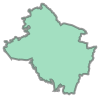

In [ ]:
# Commented out: Alternative way to load data using pickle.
# pkl.load(open(path_file, "rb"))

# Load the crime point data from a CSV file.
# This likely loads pre-generated synthetic points, replacing previous data variables.
# The path is relative to the current working directory.
data_bogota=pd.read_csv('data_random_BOGOTA_200.csv')

# Load the filtered localities geospatial data from a GeoJSON file.
# This reloads the filtered data saved in cell 2.
# The path is relative to the current working directory.
localidades=gpd.read_file('localidades_filtrada.geojson')

# Extract the geometry objects from the localities GeoDataFrame into a GeoSeries.
geometrias=gpd.GeoSeries([i for i in localidades.geometry])
# Create a single geometric object by taking the union of all locality geometries.
# This defines the combined boundary of the filtered region.
geo=geometrias.unary_union

# Display the resulting combined geometry object (implicit output).
geo

### 6. Spatially Filter Crime Data Points

This block converts the longitude and latitude columns of the crime data DataFrame into geospatial point objects. It then uses these points to filter the data, keeping only the crime events that fall within the defined geographic boundary created from the filtered localities.

In [ ]:
# Create a GeoSeries of Point objects from the longitude (column 2) and latitude (column 3) of the data_bogota DataFrame.
points= gpd.GeoSeries([Point(data_bogota.iloc[i,2] ,data_bogota.iloc[i,3] ) for i in range(len(data_bogota))])

# Filter the original data_bogota DataFrame
# Keep only the rows where the corresponding point is spatially located within the 'geo' boundary (union of filtered localities).
data_bogota_filterd=data_bogota[points.within(geo)]

# Display the first few rows of the spatially filtered DataFrame (implicit output).
data_bogota_filterd.head()

,Unnamed: 0,fecha_crimen,LONGITUD_X,LATITUD_Y
0,0,2018-01-01 04:36:19,-74.185589,4.645852
1,0,2018-01-01 13:14:32,-74.183582,4.601853
2,0,2018-01-01 22:23:04,-74.183580,4.607855
4,0,2018-01-01 10:05:40,-74.169589,4.627854
5,0,2018-01-01 09:11:25,-74.167574,4.613858


### 7. Convert to GeoDataFrame and Reproject Coordinates

This block converts the filtered crime data points into a proper GeoDataFrame format using the coordinates as the geometry. It then assigns an initial Coordinate Reference System (CRS) to the data and reprojects it to a planar CRS suitable for accurate distance and area calculations. Finally, it extracts the reprojected planar coordinates into new columns.

In [ ]:
# Create a list of Point objects from the longitude (column 2) and latitude (column 3) of the filtered DataFrame.
geometria=[ Point(data_bogota_filterd.iloc[i,2],data_bogota_filterd.iloc[i,3]) for i in range(len(data_bogota_filterd))]

# Create a new GeoDataFrame using the filtered DataFrame and the list of Point objects as the geometry.
geo_pandas_bog=gpd.GeoDataFrame(data=data_bogota_filterd,geometry=geometria)

# Assign the initial Coordinate Reference System (CRS) to the GeoDataFrame (WGS 84, standard lat/lon).
geo_pandas_bog.crs = 'EPSG:4326'

# Reproject the GeoDataFrame to a planar CRS (EPSG:3116, likely a projected system for Bogota/Colombia).
# This is necessary for accurate spatial measurements.
geo_pandas_bog_planas = geo_pandas_bog.to_crs(epsg=3116)

# Extract the x and y coordinates from the reprojected planar geometry and store them in new columns.
geo_pandas_bog_planas['coord_x']=geo_pandas_bog_planas.geometry.apply(lambda x: x.x)
geo_pandas_bog_planas['coord_y']=geo_pandas_bog_planas.geometry.apply(lambda x: x.y)

# Display the first few rows of the reprojected GeoDataFrame with new coordinate columns (implicit output).
geo_pandas_bog_planas.head()

,Unnamed: 0,fecha_crimen,LONGITUD_X,LATITUD_Y,geometry,coord_x,coord_y
0,0,2018-01-01 04:36:19,-74.185589,4.645852,POINT (988007.750 1005491.420),988007.750288,1.005491e+06
1,0,2018-01-01 13:14:32,-74.183582,4.601853,POINT (988229.644 1000625.979),988229.644451,1.000626e+06
2,0,2018-01-01 22:23:04,-74.183580,4.607855,POINT (988230.010 1001289.658),988230.010110,1.001290e+06
4,0,2018-01-01 10:05:40,-74.169589,4.627854,POINT (989782.789 1003500.997),989782.788796,1.003501e+06
5,0,2018-01-01 09:11:25,-74.167574,4.613858,POINT (990006.177 1001953.198),990006.176771,1.001953e+06


### 8. Prepare Data for OpenCP and Save Processed Objects

This block converts the processed crime data points into the `open_cp.TimedPoints` format required by the `open_cp` library. It then re-processes the filtered locality geometries to create the overall geographic boundary and the reprojected locality GeoDataFrame. Finally, it saves the `open_cp.TimedPoints` object, the geographic boundary, and the reprojected localities GeoDataFrame to pickle and GeoJSON files for later use.

In [ ]:
# Parse the 'fecha_crimen' column into datetime objects.
timestamps = geo_pandas_bog_planas.fecha_crimen.map(dateutil.parser.parse)
# Extract the reprojected x and y coordinates into numpy arrays.
xcoords, ycoords = (geo_pandas_bog_planas.coord_x.values, geo_pandas_bog_planas.coord_y.values)
# Create an open_cp.TimedPoints object from the timestamps and coordinates.
crime_point_bog_opencp = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)

# Re-process locality data (CRS assignment, reprojection, geometry union).
# NOTE: This data was processed similarly in previous cells.
localidades.crs = 'EPSG:4326' # Assign initial CRS
localidades_planas = localidades.to_crs(epsg=3116) # Reproject to planar CRS
geometrias=gpd.GeoSeries([i for i in localidades_planas.geometry]) # Get reprojected geometries
geo=geometrias.unary_union # Union geometries to get combined boundary

# Save key processed data objects to files for later use.
# File paths are relative to the current working directory.
# NOTE: Ensure the target directory is writable.
pkl.dump(crime_point_bog_opencp, open('data_random_BOGOTA_200_opencp.pkl', "wb")) # Save TimedPoints object
pkl.dump(geo, open('geo_bogota.pkl', "wb")) # Save combined boundary geometry
pkl.dump(localidades_planas, open('localidades_filtrada_planas.pkl', "wb")) # Save reprojected localities GeoDataFrame

# Save the GeoDataFrames to GeoJSON files.
geo_pandas_bog_planas.to_file('data_random_BOGOTA_200_localidades.geojson',driver='GeoJSON') # Save crime points GeoDataFrame
localidades_planas.to_file('localidades_filtrada_planas.geojson',driver='GeoJSON') # Save reprojected localities GeoDataFrame (redundant save if pickled)


# Display the shape (number of rows, number of columns) of the crime points GeoDataFrame (implicit output).
geo_pandas_bog_planas.shape

(78805, 7)

### 9. Define Analysis Region and Grid

This block reloads the filtered and reprojected localities data and its combined boundary. It calculates the bounding box of this boundary and uses these bounds to define a rectangular analysis region and a spatial grid with specified cell sizes. Finally, it masks the grid to include only areas within the geographic boundary.

In [ ]:
# Load the filtered and reprojected localities GeoJSON file
# This reloads the file saved in a previous step.
# The path is relative to the current working directory.
localidades=gpd.read_file('localidades_filtrada_planas.geojson')
# Re-create GeoSeries from geometries
geometrias=gpd.GeoSeries([i for i in localidades.geometry])
# Re-create the union geometry object representing the total boundary
geo=geometrias.unary_union

# Commented-out code showing how to calculate bounds from crime data points
# maxx = max(data_bogota.LONGITUD_X)
# minx = min(data_bogota.LONGITUD_X)
# maxy = max(data_bogota.LATITUD_Y)
# miny = min(data_bogota.LATITUD_Y)

# Calculate min/max bounds from the boundary geometry
minx=geo.bounds[0]
miny=geo.bounds[1]
maxx=geo.bounds[2]
maxy=geo.bounds[3]

# Calculate the range of coordinates
x_range=abs(maxx-minx)
y_range=abs(maxy-miny)
range_max=max(x_range,y_range)

# Define a rectangular region for analysis using calculated minx/miny and hardcoded size
# NOTE: The size (25000x25000) is fixed, not based on the data range.
region = open_cp.RectangularRegion(xmin=minx, xmax=minx+25*1000, ymin=miny, ymax=miny+25*1000)
# Commented-out alternative region definition
# region = open_cp.RectangularRegion(xmin=0, xmax=1, ymin=0, ymax=1)

# Define a spatial grid with specified cell size (1000x1000) starting from minx/miny
grid = open_cp.data.Grid(xsize=1000, ysize=1000, xoffset=minx, yoffset=miny)
# Mask the grid using the geographic boundary (geo)
# This keeps only the grid cells that intersect with the defined region.
grid2 = open_cp.geometry.mask_grid_by_intersection(geo, grid)

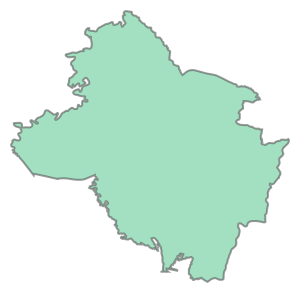

In [ ]:
geo

In [ ]:
geo.bounds

(983791.7606360756, 990282.2316803448, 1010094.3256417089, 1015914.8883224407)

### 10. Save Defined Spatial Objects

This block creates a GeoDataFrame representing the bounding box of the analysis region's boundary. It then saves this bounding box GeoDataFrame as a GeoJSON file and saves the defined rectangular region, the masked grid, and the unmasked grid objects as pickle files. These saved files store the key spatial configurations determined in previous steps for potential reuse.

In [ ]:
# Create a GeoDataFrame for the bounding box of the 'geo' boundary.
# The polygon is created using the bounds (minx, miny, maxx, maxy) obtained from the projected 'geo' object.
bounding=gpd.GeoDataFrame({'geometry':[Polygon([(geo.bounds[0], geo.bounds[1])
                        , (geo.bounds[0], geo.bounds[3])
                        , (geo.bounds[2], geo.bounds[3])
                        , (geo.bounds[2], geo.bounds[1])])]})
# Set the CRS of the bounding box GeoDataFrame.
# NOTE: The polygon coordinates are from the projected 'geo' (EPSG:3116), but the CRS is set to EPSG:4326 (lat/lon), which might be incorrect.
bounding.crs = "EPSG:4326"

# Save the bounding box GeoDataFrame to a GeoJSON file.
# The path is relative to the current working directory.
# NOTE: Ensure the target directory is writable.
bounding.to_file('bounding_box.geojson',driver='GeoJSON')

# Save the defined region and grid objects to pickle files.
# These paths are relative to the current working directory.
# NOTE: Ensure the target directory is writable.
pkl.dump(region, open('definition_region.pkl', "wb")) # Save the RectangularRegion object
pkl.dump(grid2, open('grilla1_region.pkl', "wb")) # Save the masked grid object
pkl.dump(grid, open('grilla2_region.pkl', "wb")) # Save the unmasked grid object

# Display the bounding box GeoDataFrame (implicit output).
bounding

,geometry
0,"POLYGON ((983791.76064 990282.23168, 983791.76..."


### 11. Load Saved Spatial Configuration Objects

This block loads several key spatial configuration objects and data from pickle and GeoJSON files that were previously created and saved in earlier steps. This includes loading the masked and unmasked grid objects, the defined rectangular region, the combined geographic boundary, and the reprojected localities GeoDataFrame. This step ensures that the necessary spatial definitions are available in memory for subsequent modeling or analysis.

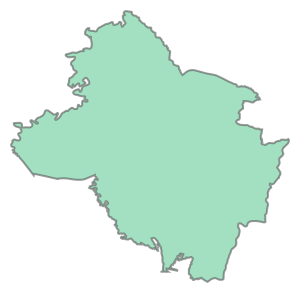

In [ ]:
# Load previously saved grid and region objects from pickle files.
# File paths are relative to the current working directory.
grid1=pkl.load(open('grilla1_region.pkl', "rb")) # Load the masked grid
grid2=pkl.load(open('grilla2_region.pkl', "rb")) # Load the unmasked grid
region=pkl.load(open('definition_region.pkl', "rb")) # Load the rectangular region
geo=pkl.load(open('geo_bogota.pkl', "rb")) # Load the combined geographic boundary

# Load the filtered and reprojected localities GeoDataFrame from a GeoJSON file.
# This reloads the file saved previously. The path is relative to the current working directory.
localidades=gpd.read_file('localidades_filtrada_planas.geojson')

# Display the loaded combined geographic boundary object (implicit output).
geo

### 12. Calculate Grid Dimensions for Mask

This block calculates coordinate boundaries based on the overall geographic boundary and a fixed offset. It then defines grid cell dimensions and initializes an empty NumPy array of a size corresponding to a grid that would cover the calculated boundary area with the defined cell dimensions. This array is likely intended for use as a mask or container for grid-based data.

In [ ]:
# Calculate two coordinate points based on the bounds of the 'geo' boundary and a fixed offset (25000 units).
# These points likely define the corners of a larger rectangular area of interest.
inferior = (geo.bounds[0], geo.bounds[1]) # Bottom-left corner (based on geo bounds)
superior = (geo.bounds[0]+25*1000, geo.bounds[1]+25*1000) # Top-right corner (based on geo bounds + offset)

# Commented-out definitions for longitude and width in degrees or meters.
# longitud = 0.002/111.319 # 200 meters in degrees approximately
# ancho = 0.002/111.319 # 200 meters in degrees approximately
# longitud = 1/111.319 # 200 meters in degrees approximately
# ancho = 1/111.319 # 200 meters in degrees approximately

# Define the length and width of a grid cell in the projected coordinates (likely meters).
longitud=1000 # Cell size in x-direction
ancho=1000 # Cell size in y-direction

# Create an empty NumPy array with dimensions calculated based on the total range and cell size.
# This array's shape corresponds to the number of grid cells needed to cover the area from 'inferior' to 'superior' with 'longitud'x'ancho' cells.
mask = np.empty([ int((superior[1] - inferior[1]) / ancho) , int((superior[0] - inferior[0]) / longitud)])

# Display the shape (dimensions) of the created mask array (implicit output).
mask.shape

(25, 25)

### 13. Build Grid GeoDataFrame and Create Locality Mask

This block constructs a GeoDataFrame representing a grid of polygons covering the previously defined analysis area. Simultaneously, it iterates through each grid cell, checks which locality (from the filtered localities data) it intersects, and builds a list of lists (`mask`) containing the locality code for each cell, using 0 if no locality intersects. This process creates both a geometric representation of the grid and a corresponding grid-like mask indicating the locality of each cell.

In [ ]:
# Initialize counters and an empty GeoDataFrame to build the grid.
county=0 # Row counter for the grid
cuadricula_bog=gpd.GeoDataFrame() # GeoDataFrame to store grid cell polygons
mask=[] # Re-initialize mask as an empty list (overwrites any previous 'mask' variable)

# Loop through the rows and columns corresponding to the dimensions calculated in cell 12.
# This iterates through each potential grid cell in the defined area.
for y in tqdm(range(int((superior[1] - inferior[1]) / ancho))): # Outer loop for rows (y-direction) with progress bar
  countx=0 # Column counter for the current row
  vector_x=[] # List to store locality codes (or 0) for the current row

  for x in range(int((superior[0] - inferior[0]) / longitud)): # Inner loop for columns (x-direction)
    # Calculate the coordinates for the vertices of the current grid cell (square).
    xmin = inferior[0] + x * longitud
    xmax = xmin + longitud
    ymin = inferior[1] + y * ancho
    ymax = ymin + ancho

    # Create a Polygon object for the current grid cell.
    square = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])

    # Create a temporary GeoDataFrame for the current square and concatenate it to the main grid GeoDataFrame.
    cuadricula_bog=pd.concat([cuadricula_bog,gpd.GeoDataFrame({'geometry':[square]})])

    # Try to find which locality the current grid cell intersects and get its code.
    try:
      # Commented out: Original attempt to populate a 2D mask array directly.
      # mask[countx][county]=localidades[square.intersects(localidades.geometry)].reset_index(drop=True)["LocCodigo"][0]

      # Filter localities to find those intersecting the current square, reset index, and get the 'LocCodigo' of the first intersecting locality.
      # Append the found locality code to the vector_x list for the current row.
      vector_x.append(localidades[square.intersects(localidades.geometry)].reset_index(drop=True)["LocCodigo"][0])
    except:
      # If no locality intersects or an error occurs, append 0 to the vector_x list.
      vector_x.append(0)
      continue # Continue to the next grid cell in the inner loop.

    countx+=1 # Increment column counter

  # After processing a row (inner loop finishes), append the vector of locality codes for the row to the main mask list.
  # NOTE: np.transpose(vector_x) on a 1D list does not change the list. This appends the list itself.
  mask.append(np.transpose(vector_x))
  county+=1 # Increment row counter (outer loop)

100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


### 14. Finalize Locality Mask, Grid, and Define Protected Regions

This block converts the list-based mask created in the previous step into a NumPy array, assigns the correct CRS to the grid GeoDataFrame, and saves both the grid GeoDataFrame and the mask array to files. It also defines lists containing the specific locality codes designated as 'protected' and 'non-protected' regions.

In [ ]:
# Convert the list 'mask' (populated with locality codes per grid cell row) into a NumPy array and cast to integer type.
# This creates the final 2D grid representation of locality codes.
mask=np.array(mask).astype(int)

# Assign the Coordinate Reference System (CRS) to the grid GeoDataFrame.
# EPSG:3116 is likely the projected CRS used for calculations.
cuadricula_bog.crs = "EPSG:3116"
# Save the grid GeoDataFrame to a GeoJSON file.
# The path is relative to the current working directory.
# NOTE: Ensure the target directory is writable.
cuadricula_bog.to_file('cuadricula_1km_bog_planas.geojson',driver='GeoJSON')

# Save the NumPy array mask (containing locality codes per grid cell) to a pickle file.
# The path is relative to the current working directory.
# NOTE: Ensure the target directory is writable.
pkl.dump(mask, open('mascara_localidades.pkl', "wb"))

# Define lists containing integer codes that correspond to 'protected' and 'non-protected' localities.
# These lists are used to identify grid cells belonging to protected/non-protected areas using the 'mask' array.
Protegidos=[3,4,6,7,10,14,15,17,18]
NoProtegidos=[2,8,9,11,12,13,16]

# Display the shape (dimensions) of the finalized mask NumPy array (implicit output).
mask.shape

(25, 25)

In [ ]:
mask

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,
         4,  4,  4,  4,  4,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4,
         4,  4,  4,  4,  4,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 18,  4,  4,
         4,  4,  4,  4,  4,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 18, 18,  4,  4,
         4,  4,  4,  4,  4,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6, 18, 18,  4,  4,
         4,  4,  4,  4,  4,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6,  6, 18, 18,  4,  4,
         4,  4,  4,  4,  4,  3,  3,  3,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  6, 18, 18, 18,  4,  4,
         4,  4,  4,  4,  3,  3,  3,  3,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  6,  6,  6, 18, 18, 15, 15,  4,
         3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  6,  6,  6,  6, 15, 15, 15, 

### 15. Create, Save, and Visualize Boolean Region Masks

This block generates boolean masks corresponding to the defined protected, non-protected, and zero-coded grid cells based on the locality code mask created earlier. These boolean masks indicate, for each cell, whether it belongs to a specific region type. The generated masks are saved to pickle files, and the protected area mask is visualized as an image.

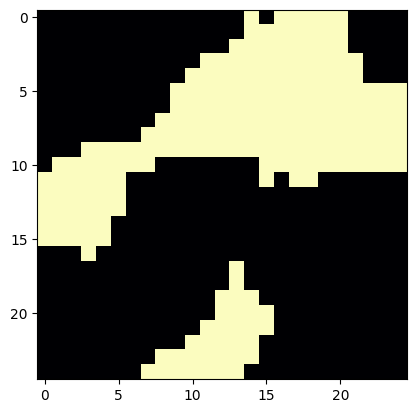

In [ ]:
# Create a boolean mask where True indicates grid cells whose locality code is in the 'Protegidos' list.
mask_protegidos=np.isin(mask,Protegidos)
# Create a boolean mask where True indicates grid cells whose locality code is in the 'NoProtegidos' list.
mask_noprotegidos=np.isin(mask,NoProtegidos)
# Create a boolean mask where True indicates grid cells whose locality code is 0.
mask_zeros=np.isin(mask,[0])

# Save the generated boolean masks to pickle files for later use.
# File paths are relative to the current working directory.
# NOTE: Ensure the target directory is writable.
pkl.dump(mask_protegidos, open('mascara_protegidos.pkl', "wb")) # Save mask for protected regions
pkl.dump(mask_noprotegidos, open('mascara_noprotegidos.pkl', "wb")) # Save mask for non-protected regions
pkl.dump(mask_zeros, open('mascara_zeros.pkl', "wb")) # Save mask for zero-coded regions

# Visualize the boolean mask for protected regions as an image using the 'magma' colormap.
plt.imshow( mask_protegidos , cmap = 'magma')

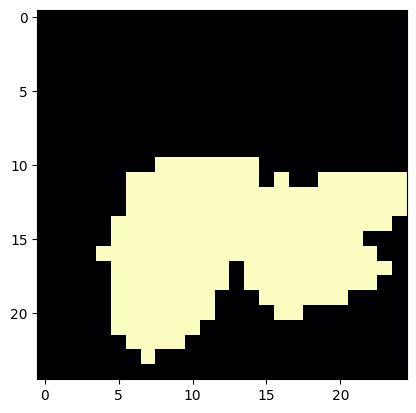

In [ ]:
# Visualize the boolean mask for unprotected regions as an image using the 'magma' colormap.
plt.imshow( mask_noprotegidos , cmap = 'magma')

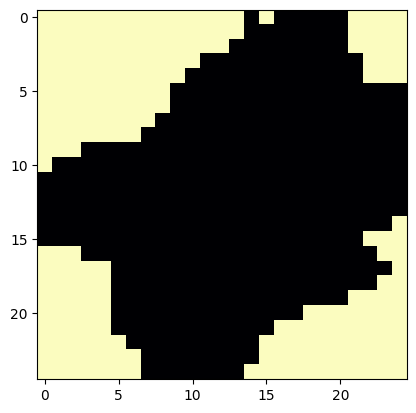

In [ ]:
# Visualize the boolean mask for others regions as an image using the 'magma' colormap.plt.imshow( mask_zeros , cmap = 'magma')
plt.imshow( mask_zeros , cmap = 'magma')

### 16. Define Event Plotting Utility and Load/Filter Data by Date

This block defines a helper function `plot_events` to visualize spatio-temporal point data. It then loads the `open_cp.TimedPoints` crime data object that was saved previously and filters this data to a specific date range (from June 2018 to the end of 2019), preparing it for subsequent analysis within this time window.

In [ ]:
# Import plotting library (redundant import, kept as in original)
import matplotlib.pyplot as plt
# Define a helper function to plot spatio-temporal event data.
# Takes TimedPoints data and date range limits for the time axis.
def plot_events(data,f_inicial,f_final):
    # Data is assumed to be raw TimedPoints data.
    # Create a figure with two subplots side-by-side.
    fig, ax = plt.subplots(ncols=2, figsize=(9,2.5))

    # Plot event coordinates (x vs y) on the first subplot.
    ax[0].scatter(data.xcoords, data.ycoords, marker="+", alpha=0.5)
    ax[0].set_title("Coordinates")
    ax[0].set_xlabel('Coordinate X')
    ax[0].set_ylabel('Coordinate Y')
    # Commented-out: Set x and y limits
    # ax[0].set(xlim=[0,1], ylim=[0,1])

    # Get event timestamps.
    times = data.times_datetime()
    # Plot time vs y-coordinate on the second subplot.
    ax[1].scatter(times, data.ycoords, marker="+", alpha=0.1)
    # Set x-axis limits based on the provided date range.
    ax[1].set_xlim([f_inicial, f_final])
    # Commented-out: Set y-limits
    # ax[1].set_ylim([0, 1])
    ax[1].set_title("Coordinate Vs Dates")
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Coordinate Y')
    # Automatically format the x-axis to display dates nicely.
    fig.autofmt_xdate()
    None # Placeholder

# Load the crime data in open_cp.TimedPoints format from a pickle file.
# This reloads the object saved in cell 8.
# The path is relative to the current working directory.
crime_point_bog_opencp = pkl.load(open("data_random_BOGOTA_200_opencp.pkl", "rb")) ## cargar datos

# Filter the TimedPoints object to keep only events within a specific date range (June 1, 2018 to Jan 1, 2020).
crime_point_bog_opencp=crime_point_bog_opencp[(crime_point_bog_opencp.times_datetime()>=np.datetime64("2018-06-01 00:00:00")) & (crime_point_bog_opencp.times_datetime()<np.datetime64("2020-01-01 00:00:00"))]

# Display the number of events (length of x-coordinates) in the filtered TimedPoints object (implicit output).
len(crime_point_bog_opencp.xcoords)

39982

### 17. Split Data into Training and Testing Sets

This block splits the crime data (`crime_point_bog_opencp`) into temporal training and testing sets. The split point is January 1, 2019; events before this date constitute the training set (`Train_bog`), and events from this date onwards constitute the testing set (`Test_bog`). Both resulting `open_cp.TimedPoints` objects are then saved to pickle files.

In [ ]:
# Create a boolean mask for timestamps before the split date (January 1, 2019).
mask_times=(crime_point_bog_opencp.times_datetime()<np.datetime64("2019-01-01 00:00:00"))

# Filter the crime data using the mask to create the training set (events before the split date).
Train_bog=crime_point_bog_opencp[mask_times]
# Print the number of events in the training set.
print(len(Train_bog.xcoords))
# Save the training set to a pickle file.
# The path is relative to the current working directory.
pkl.dump(Train_bog, open("Train_bog.pkl", "wb"))

# Filter the crime data using the inverse mask to create the testing set (events from the split date onwards).
Test_bog=crime_point_bog_opencp[~mask_times]
# Print the number of events in the testing set.
print(len(Test_bog.xcoords))
# Save the testing set to a pickle file.
# The path is relative to the current working directory.
pkl.dump(Test_bog, open("Test_bog.pkl", "wb"))

# Redundant code: Repeat the filtering and saving of the testing set.
Test_bog=crime_point_bog_opencp[~mask_times] # Re-filter test set
print(len(Test_bog.xcoords)) # Re-print length
pkl.dump(Test_bog, open("Test_bog.pkl", "wb")) # Re-save test set

14397
25585


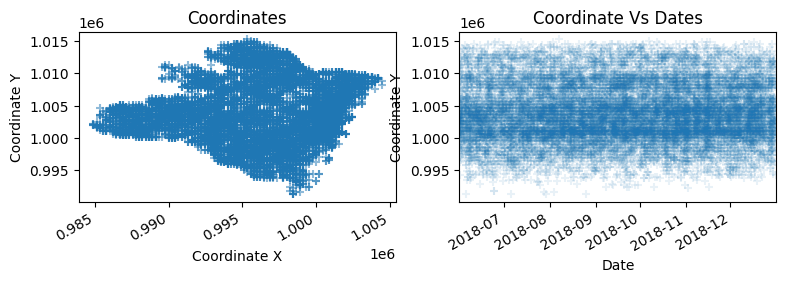

In [ ]:
plot_events(Train_bog,*Train_bog.time_range)

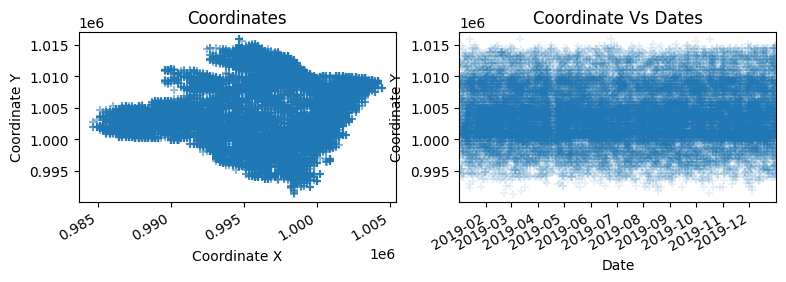

In [ ]:
plot_events(Test_bog,*Test_bog.time_range)

### 18. Load Analysis Region and Full Crime Data

This block loads the previously saved rectangular analysis region object and the full set of crime data points in the `open_cp.TimedPoints` format from pickle files. It then calculates and displays the temporal range (minimum and maximum timestamps) and the total number of events in the loaded crime data.

In [ ]:
# Commented-out lines to load training and testing data from pickle files.
# Train_bog = pkl.load(open("Train_bog.pkl", "rb")) ## cargar datos
# Test_bog = pkl.load(open("Test_bog.pkl", "rb")) ## cargar datos

# Load the rectangular analysis region object from a pickle file.
# The path is relative to the current working directory.
region = pkl.load(open("definition_region.pkl", "rb")) ## cargar datos

# Load the full crime data in open_cp.TimedPoints format from a pickle file.
# This loads the data after spatial filtering but before any temporal splits, overwriting previous data variables.
# The path is relative to the current working directory.
crime_point_bog = pkl.load(open("data_random_BOGOTA_200_opencp.pkl", "rb")) ## cargar datos

# Calculate and display the maximum timestamp, minimum timestamp, and the total count of events in the loaded data (implicit output).
max(crime_point_bog.times_datetime()),min(crime_point_bog.times_datetime()),len(crime_point_bog.times_datetime())

(datetime.datetime(2021, 5, 31, 23, 44, 17),
 datetime.datetime(2018, 1, 1, 1, 10, 29),
 78805)

### 19. Import Models and Define Utility Functions

This block imports model classes and time unit utilities. It defines intensity_m to normalize model predictions into a grid and get_real_m to convert real event data for a day into a normalized grid. These functions standardize data for evaluation.

In [ ]:
# Import model classes and time unit utilities
from models.model_selection import NAIVE_MODEL, KDE_MODEL, SEPP_MODEL
from open_cp.sources.sepp import make_time_unit
from global_vars import days_time_unit
#import datetime # Commented out import
from datetime import timedelta

# Function to convert model prediction to normalized intensity matrix
def intensity_m(model,date,region,grid_size):
    try:
        # Get prediction (with or without date)
        predict=model.predict(date)
    except:
        predict=model.predict()

    try:
        # Convert continuous prediction to grid
        M=open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(predict, region, grid_size, grid_size)
        intensity_matrix= M.intensity_matrix
    except:
        # If already grid-based, get matrix
        intensity_matrix = predict.intensity_matrix

    # Normalize unless sum is zero
    if intensity_matrix.sum()==0:
        return intensity_matrix
    else:
        return intensity_matrix/intensity_matrix.sum()

### Function to get real data intensity matrix
import open_cp.naive as naive
# Function to convert real event data for a day into a normalized grid
def get_real_m(timedpoints,p_date,grid_size,region):
    # Filter events for the specific date
    real = timedpoints[(timedpoints.times_datetime()>=p_date) & ((timedpoints.times_datetime()<p_date+timedelta(days=1)))]
    # Create counting grid predictor
    predictor = naive.CountingGridKernel(grid_size,grid_size,region=region) # Note: grid_size appears twice
    # Set data for predictor
    predictor.data = real
    try:
        # Predict, re-normalize, and get matrix
        gridpred = predictor.predict().renormalise()
        real=gridpred.intensity_matrix.data
        return real
    except:
        # If re-normalization fails, return raw matrix
        return predictor.predict().intensity_matrix


Failed to load 'descartes' package.
Failed to import `rtree`.


In [5]:
t=np.arange(datetime(2018,2,1,0,0),datetime(2019,12,31,0,0),timedelta(days=1)).astype(datetime)
t=[datetime(2018, 2, 1, 0, 0), datetime(2018, 2, 2, 0, 0), datetime(2018, 2, 3, 0, 0), datetime(2018, 2, 4, 0, 0), datetime(2018, 2, 5, 0, 0), datetime(2018, 2, 6, 0, 0), datetime(2018, 2, 7, 0, 0), datetime(2018, 3, 10, 0, 0), datetime(2018, 3, 11, 0, 0), datetime(2018, 3, 12, 0, 0), datetime(2018, 3, 13, 0, 0), datetime(2018, 3, 14, 0, 0), datetime(2018, 3, 15, 0, 0), datetime(2018, 3, 16, 0, 0), datetime(2018, 4, 16, 0, 0), datetime(2018, 4, 17, 0, 0), datetime(2018, 4, 18, 0, 0), datetime(2018, 4, 19, 0, 0), datetime(2018, 4, 20, 0, 0), datetime(2018, 4, 21, 0, 0), datetime(2018, 4, 22, 0, 0), datetime(2018, 4, 23, 0, 0), datetime(2018, 4, 24, 0, 0), datetime(2018, 5, 25, 0, 0), datetime(2018, 5, 26, 0, 0), datetime(2018, 5, 27, 0, 0), datetime(2018, 6, 27, 0, 0), datetime(2018, 6, 28, 0, 0), datetime(2018, 6, 29, 0, 0), datetime(2018, 6, 30, 0, 0), datetime(2018, 7, 1, 0, 0), datetime(2018, 7, 2, 0, 0), datetime(2018, 7, 3, 0, 0), datetime(2018, 7, 4, 0, 0), datetime(2018, 7, 5, 0, 0), datetime(2018, 7, 6, 0, 0), datetime(2018, 7, 7, 0, 0), datetime(2018, 7, 8, 0, 0), datetime(2018, 7, 9, 0, 0), datetime(2018, 7, 10, 0, 0), datetime(2018, 7, 11, 0, 0), datetime(2018, 7, 12, 0, 0), datetime(2018, 7, 13, 0, 0), datetime(2018, 7, 14, 0, 0), datetime(2018, 7, 15, 0, 0), datetime(2018, 7, 16, 0, 0), datetime(2018, 7, 17, 0, 0), datetime(2018, 7, 18, 0, 0), datetime(2018, 7, 19, 0, 0), datetime(2018, 7, 20, 0, 0), datetime(2018, 7, 21, 0, 0), datetime(2018, 7, 22, 0, 0), datetime(2018, 7, 23, 0, 0), datetime(2018, 7, 24, 0, 0), datetime(2018, 7, 25, 0, 0), datetime(2018, 7, 26, 0, 0), datetime(2018, 7, 27, 0, 0), datetime(2018, 7, 28, 0, 0), datetime(2018, 7, 29, 0, 0), datetime(2018, 7, 30, 0, 0), datetime(2018, 7, 31, 0, 0), datetime(2018, 8, 1, 0, 0), datetime(2018, 8, 2, 0, 0), datetime(2018, 8, 3, 0, 0), datetime(2018, 8, 4, 0, 0), datetime(2018, 8, 5, 0, 0), datetime(2018, 8, 6, 0, 0), datetime(2018, 8, 7, 0, 0), datetime(2018, 8, 8, 0, 0), datetime(2018, 8, 9, 0, 0), datetime(2018, 8, 10, 0, 0), datetime(2018, 8, 11, 0, 0), datetime(2018, 8, 12, 0, 0), datetime(2018, 8, 13, 0, 0), datetime(2018, 8, 14, 0, 0), datetime(2018, 8, 15, 0, 0), datetime(2018, 8, 16, 0, 0), datetime(2018, 8, 17, 0, 0), datetime(2018, 8, 18, 0, 0), datetime(2018, 8, 19, 0, 0), datetime(2018, 8, 20, 0, 0), datetime(2018, 8, 21, 0, 0), datetime(2018, 8, 22, 0, 0), datetime(2018, 8, 23, 0, 0), datetime(2018, 8, 25, 0, 0), datetime(2018, 8, 26, 0, 0), datetime(2018, 8, 27, 0, 0), datetime(2018, 8, 28, 0, 0), datetime(2018, 8, 29, 0, 0), datetime(2018, 8, 30, 0, 0), datetime(2018, 8, 31, 0, 0), datetime(2018, 9, 1, 0, 0), datetime(2018, 9, 2, 0, 0), datetime(2018, 9, 3, 0, 0), datetime(2018, 9, 5, 0, 0), datetime(2018, 9, 6, 0, 0), datetime(2018, 9, 7, 0, 0), datetime(2018, 9, 8, 0, 0), datetime(2018, 9, 9, 0, 0), datetime(2018, 9, 10, 0, 0), datetime(2018, 9, 11, 0, 0), datetime(2018, 8, 24, 0, 0), datetime(2018, 9, 4, 0, 0), datetime(2018, 9, 12, 0, 0), datetime(2018, 9, 13, 0, 0), datetime(2018, 9, 14, 0, 0), datetime(2018, 9, 15, 0, 0), datetime(2018, 9, 16, 0, 0), datetime(2018, 9, 17, 0, 0), datetime(2018, 9, 18, 0, 0), datetime(2018, 9, 19, 0, 0), datetime(2018, 9, 20, 0, 0), datetime(2018, 9, 21, 0, 0), datetime(2018, 9, 22, 0, 0), datetime(2018, 9, 23, 0, 0), datetime(2018, 9, 24, 0, 0), datetime(2018, 9, 25, 0, 0), datetime(2018, 9, 26, 0, 0), datetime(2018, 9, 27, 0, 0), datetime(2018, 9, 28, 0, 0), datetime(2018, 9, 29, 0, 0), datetime(2018, 9, 30, 0, 0), datetime(2018, 10, 1, 0, 0), datetime(2018, 10, 2, 0, 0), datetime(2018, 10, 3, 0, 0), datetime(2018, 10, 4, 0, 0), datetime(2018, 10, 5, 0, 0), datetime(2018, 10, 6, 0, 0), datetime(2018, 10, 7, 0, 0), datetime(2018, 10, 8, 0, 0), datetime(2018, 10, 9, 0, 0), datetime(2018, 10, 10, 0, 0), datetime(2018, 10, 11, 0, 0), datetime(2018, 10, 12, 0, 0), datetime(2018, 10, 13, 0, 0), datetime(2018, 10, 14, 0, 0), datetime(2018, 10, 15, 0, 0), datetime(2018, 10, 16, 0, 0), datetime(2018, 10, 17, 0, 0), datetime(2018, 10, 18, 0, 0), datetime(2018, 10, 19, 0, 0), datetime(2018, 10, 20, 0, 0), datetime(2018, 10, 21, 0, 0), datetime(2018, 10, 22, 0, 0), datetime(2018, 10, 23, 0, 0), datetime(2018, 10, 24, 0, 0), datetime(2018, 10, 25, 0, 0), datetime(2018, 10, 26, 0, 0), datetime(2018, 10, 27, 0, 0), datetime(2018, 10, 28, 0, 0), datetime(2018, 10, 29, 0, 0), datetime(2018, 10, 30, 0, 0), datetime(2018, 10, 31, 0, 0), datetime(2018, 11, 1, 0, 0), datetime(2018, 11, 2, 0, 0), datetime(2018, 11, 3, 0, 0), datetime(2018, 11, 4, 0, 0), datetime(2018, 11, 5, 0, 0), datetime(2018, 11, 6, 0, 0), datetime(2018, 11, 7, 0, 0), datetime(2018, 11, 8, 0, 0), datetime(2018, 11, 9, 0, 0), datetime(2018, 11, 10, 0, 0), datetime(2018, 11, 11, 0, 0), datetime(2018, 11, 12, 0, 0), datetime(2018, 11, 13, 0, 0), datetime(2018, 11, 14, 0, 0), datetime(2018, 11, 15, 0, 0), datetime(2018, 11, 16, 0, 0), datetime(2018, 11, 17, 0, 0), datetime(2018, 11, 18, 0, 0), datetime(2018, 11, 19, 0, 0), datetime(2018, 11, 20, 0, 0), datetime(2018, 11, 21, 0, 0), datetime(2018, 11, 22, 0, 0), datetime(2018, 11, 23, 0, 0), datetime(2018, 11, 24, 0, 0), datetime(2018, 11, 25, 0, 0), datetime(2018, 11, 26, 0, 0), datetime(2018, 11, 27, 0, 0), datetime(2018, 11, 28, 0, 0), datetime(2018, 11, 29, 0, 0), datetime(2018, 11, 30, 0, 0), datetime(2018, 12, 1, 0, 0), datetime(2018, 12, 2, 0, 0), datetime(2018, 12, 3, 0, 0), datetime(2018, 12, 4, 0, 0), datetime(2018, 12, 5, 0, 0), datetime(2018, 12, 6, 0, 0), datetime(2018, 12, 7, 0, 0), datetime(2018, 12, 8, 0, 0), datetime(2018, 12, 9, 0, 0), datetime(2018, 12, 10, 0, 0), datetime(2018, 12, 11, 0, 0), datetime(2018, 12, 12, 0, 0), datetime(2018, 12, 13, 0, 0), datetime(2018, 12, 14, 0, 0), datetime(2018, 12, 15, 0, 0), datetime(2018, 12, 16, 0, 0), datetime(2018, 12, 17, 0, 0), datetime(2018, 12, 18, 0, 0), datetime(2018, 12, 19, 0, 0), datetime(2018, 12, 20, 0, 0), datetime(2018, 12, 21, 0, 0), datetime(2018, 12, 22, 0, 0), datetime(2018, 12, 23, 0, 0), datetime(2018, 12, 24, 0, 0), datetime(2018, 12, 25, 0, 0), datetime(2018, 12, 26, 0, 0), datetime(2018, 12, 27, 0, 0), datetime(2018, 12, 28, 0, 0), datetime(2018, 12, 29, 0, 0), datetime(2018, 12, 30, 0, 0), datetime(2018, 12, 31, 0, 0), datetime(2019, 1, 1, 0, 0), datetime(2019, 1, 2, 0, 0), datetime(2019, 1, 3, 0, 0), datetime(2019, 1, 4, 0, 0), datetime(2019, 1, 5, 0, 0), datetime(2019, 1, 6, 0, 0), datetime(2019, 1, 7, 0, 0), datetime(2019, 1, 8, 0, 0), datetime(2019, 1, 9, 0, 0), datetime(2019, 1, 10, 0, 0), datetime(2019, 1, 11, 0, 0), datetime(2019, 1, 12, 0, 0), datetime(2019, 1, 13, 0, 0), datetime(2019, 2, 13, 0, 0), datetime(2019, 2, 14, 0, 0), datetime(2019, 2, 15, 0, 0), datetime(2019, 2, 16, 0, 0), datetime(2019, 2, 17, 0, 0), datetime(2019, 2, 18, 0, 0), datetime(2019, 2, 19, 0, 0), datetime(2019, 2, 20, 0, 0), datetime(2019, 2, 21, 0, 0), datetime(2019, 2, 22, 0, 0), datetime(2019, 2, 23, 0, 0), datetime(2019, 2, 24, 0, 0), datetime(2019, 2, 25, 0, 0), datetime(2019, 2, 26, 0, 0), datetime(2019, 2, 27, 0, 0), datetime(2019, 2, 28, 0, 0), datetime(2019, 3, 1, 0, 0), datetime(2019, 3, 2, 0, 0), datetime(2019, 3, 3, 0, 0), datetime(2019, 3, 4, 0, 0), datetime(2019, 3, 5, 0, 0), datetime(2019, 3, 6, 0, 0), datetime(2019, 3, 7, 0, 0), datetime(2019, 3, 8, 0, 0), datetime(2019, 3, 9, 0, 0), datetime(2019, 3, 10, 0, 0), datetime(2019, 3, 11, 0, 0), datetime(2019, 4, 11, 0, 0), datetime(2019, 4, 12, 0, 0), datetime(2019, 4, 13, 0, 0), datetime(2019, 4, 14, 0, 0), datetime(2019, 4, 15, 0, 0), datetime(2019, 4, 16, 0, 0), datetime(2019, 4, 17, 0, 0), datetime(2019, 4, 18, 0, 0), datetime(2019, 4, 19, 0, 0), datetime(2019, 4, 20, 0, 0), datetime(2019, 4, 21, 0, 0), datetime(2019, 4, 22, 0, 0), datetime(2019, 4, 23, 0, 0), datetime(2019, 4, 24, 0, 0), datetime(2019, 4, 25, 0, 0), datetime(2019, 4, 26, 0, 0), datetime(2019, 4, 27, 0, 0), datetime(2019, 4, 28, 0, 0), datetime(2019, 4, 29, 0, 0), datetime(2019, 4, 30, 0, 0), datetime(2019, 5, 1, 0, 0), datetime(2019, 5, 2, 0, 0), datetime(2019, 5, 3, 0, 0), datetime(2019, 5, 4, 0, 0), datetime(2019, 5, 5, 0, 0), datetime(2019, 5, 6, 0, 0), datetime(2019, 5, 7, 0, 0), datetime(2019, 5, 8, 0, 0), datetime(2019, 5, 9, 0, 0), datetime(2019, 5, 10, 0, 0), datetime(2019, 5, 11, 0, 0), datetime(2019, 5, 12, 0, 0), datetime(2019, 5, 13, 0, 0), datetime(2019, 5, 14, 0, 0), datetime(2019, 5, 15, 0, 0), datetime(2019, 5, 16, 0, 0), datetime(2019, 5, 17, 0, 0), datetime(2019, 5, 18, 0, 0), datetime(2019, 5, 19, 0, 0), datetime(2019, 5, 20, 0, 0), datetime(2019, 5, 21, 0, 0), datetime(2019, 5, 22, 0, 0), datetime(2019, 5, 23, 0, 0), datetime(2019, 5, 24, 0, 0), datetime(2019, 5, 25, 0, 0), datetime(2019, 5, 26, 0, 0), datetime(2019, 5, 27, 0, 0), datetime(2019, 5, 28, 0, 0), datetime(2019, 5, 29, 0, 0), datetime(2019, 5, 30, 0, 0), datetime(2019, 5, 31, 0, 0), datetime(2019, 6, 1, 0, 0), datetime(2019, 6, 2, 0, 0), datetime(2019, 6, 3, 0, 0), datetime(2019, 6, 4, 0, 0), datetime(2019, 6, 5, 0, 0), datetime(2019, 6, 6, 0, 0), datetime(2019, 6, 7, 0, 0), datetime(2019, 6, 8, 0, 0), datetime(2019, 6, 9, 0, 0), datetime(2019, 6, 10, 0, 0), datetime(2019, 6, 11, 0, 0), datetime(2019, 6, 12, 0, 0), datetime(2019, 6, 13, 0, 0), datetime(2019, 6, 14, 0, 0), datetime(2019, 6, 15, 0, 0), datetime(2019, 6, 16, 0, 0), datetime(2019, 6, 17, 0, 0), datetime(2019, 6, 18, 0, 0), datetime(2019, 6, 19, 0, 0), datetime(2019, 6, 20, 0, 0), datetime(2019, 6, 21, 0, 0), datetime(2019, 6, 22, 0, 0), datetime(2019, 6, 23, 0, 0), datetime(2019, 6, 24, 0, 0), datetime(2019, 7, 25, 0, 0), datetime(2019, 7, 26, 0, 0), datetime(2019, 7, 27, 0, 0), datetime(2019, 7, 28, 0, 0), datetime(2019, 7, 29, 0, 0), datetime(2019, 7, 30, 0, 0), datetime(2019, 7, 31, 0, 0), datetime(2019, 8, 1, 0, 0), datetime(2019, 8, 2, 0, 0), datetime(2019, 8, 3, 0, 0), datetime(2019, 8, 4, 0, 0), datetime(2019, 8, 5, 0, 0), datetime(2019, 8, 6, 0, 0), datetime(2019, 8, 7, 0, 0), datetime(2019, 8, 8, 0, 0), datetime(2019, 8, 9, 0, 0), datetime(2019, 8, 10, 0, 0), datetime(2019, 8, 11, 0, 0), datetime(2019, 8, 12, 0, 0), datetime(2019, 8, 13, 0, 0), datetime(2019, 8, 14, 0, 0), datetime(2019, 8, 15, 0, 0), datetime(2019, 8, 16, 0, 0), datetime(2019, 8, 17, 0, 0), datetime(2019, 8, 18, 0, 0), datetime(2019, 8, 19, 0, 0), datetime(2019, 8, 20, 0, 0), datetime(2019, 8, 21, 0, 0), datetime(2019, 8, 22, 0, 0), datetime(2019, 8, 23, 0, 0), datetime(2019, 8, 24, 0, 0), datetime(2019, 8, 25, 0, 0), datetime(2019, 8, 26, 0, 0), datetime(2019, 8, 27, 0, 0), datetime(2019, 8, 28, 0, 0), datetime(2019, 8, 29, 0, 0), datetime(2019, 8, 30, 0, 0), datetime(2019, 8, 31, 0, 0), datetime(2019, 9, 1, 0, 0), datetime(2019, 9, 2, 0, 0), datetime(2019, 9, 3, 0, 0), datetime(2019, 9, 4, 0, 0), datetime(2019, 9, 5, 0, 0), datetime(2019, 9, 6, 0, 0), datetime(2019, 9, 7, 0, 0), datetime(2019, 9, 8, 0, 0), datetime(2019, 9, 9, 0, 0), datetime(2019, 9, 10, 0, 0), datetime(2019, 9, 11, 0, 0), datetime(2019, 9, 12, 0, 0), datetime(2019, 9, 13, 0, 0), datetime(2019, 9, 14, 0, 0), datetime(2019, 9, 15, 0, 0), datetime(2019, 9, 16, 0, 0), datetime(2019, 9, 17, 0, 0), datetime(2019, 9, 18, 0, 0), datetime(2019, 9, 19, 0, 0), datetime(2019, 9, 20, 0, 0), datetime(2019, 9, 21, 0, 0), datetime(2019, 9, 22, 0, 0), datetime(2019, 9, 23, 0, 0), datetime(2019, 9, 24, 0, 0), datetime(2019, 9, 25, 0, 0), datetime(2019, 9, 26, 0, 0), datetime(2019, 9, 27, 0, 0), datetime(2019, 9, 28, 0, 0), datetime(2019, 9, 29, 0, 0), datetime(2019, 9, 30, 0, 0), datetime(2019, 11, 16, 0, 0), datetime(2019, 11, 17, 0, 0), datetime(2019, 11, 18, 0, 0), datetime(2019, 11, 19, 0, 0), datetime(2019, 11, 20, 0, 0), datetime(2019, 11, 21, 0, 0), datetime(2019, 11, 22, 0, 0), datetime(2019, 11, 23, 0, 0), datetime(2019, 11, 24, 0, 0), datetime(2019, 11, 25, 0, 0), datetime(2019, 11, 26, 0, 0), datetime(2019, 11, 27, 0, 0), datetime(2019, 11, 28, 0, 0), datetime(2019, 11, 29, 0, 0), datetime(2019, 11, 30, 0, 0), datetime(2019, 12, 1, 0, 0), datetime(2019, 12, 2, 0, 0), datetime(2019, 12, 3, 0, 0), datetime(2019, 12, 4, 0, 0), datetime(2019, 12, 5, 0, 0), datetime(2019, 12, 6, 0, 0), datetime(2019, 12, 7, 0, 0), datetime(2019, 12, 8, 0, 0), datetime(2019, 12, 9, 0, 0), datetime(2019, 12, 10, 0, 0), datetime(2019, 12, 11, 0, 0), datetime(2019, 12, 12, 0, 0), datetime(2019, 12, 13, 0, 0), datetime(2019, 12, 14, 0, 0), datetime(2019, 12, 15, 0, 0), datetime(2019, 12, 16, 0, 0), datetime(2019, 12, 17, 0, 0), datetime(2019, 12, 18, 0, 0), datetime(2019, 12, 19, 0, 0), datetime(2019, 12, 20, 0, 0), datetime(2019, 12, 21, 0, 0), datetime(2019, 12, 22, 0, 0), datetime(2019, 12, 23, 0, 0), datetime(2019, 12, 24, 0, 0), datetime(2019, 12, 25, 0, 0), datetime(2019, 12, 26, 0, 0), datetime(2019, 12, 27, 0, 0), datetime(2019, 12, 28, 0, 0), datetime(2019, 12, 29, 0, 0), datetime(2019, 12, 30, 0, 0)]
len(t)

442

### 20. Generate KDE Predictions and Real Data Grids (Sliding Window)

This block implements the core logic for generating KDE model predictions and corresponding real data grids over a sequence of time points (t). It uses a 30-day sliding window of past data for training the model at each prediction date. Results are saved incrementally to pickle files.

In [ ]:
# Import KDE specific modules
import open_cp.kde as kde

# Check if prediction results file exists; load if it does, otherwise initialize empty dictionary.
# File path is relative to the current working directory.
if not os.path.exists(os.path.join("KDE/","predictions_window.pkl")):
    predictions={}
else:
    predictions=pkl.load(open(os.path.join("KDE/","predictions_window.pkl"), "rb"))

# Check if real data grids file exists; load if it does, otherwise initialize empty dictionary.
# File path is relative to the current working directory.
if not os.path.exists(os.path.join("KDE/","reals_window.pkl"), "rb")):
    reals={}
else:
    reals=pkl.load(open(os.path.join("KDE/","reals_window.pkl"), "rb"))

# Iterate through each time point 'i' in the sequence 't' (assuming 't' is defined elsewhere).
for i in tqdm(t): # tqdm provides a progress bar
    # Define the start and end dates for the 30-day sliding window.
    t1=i-timedelta(days=30)
    t2=i
    # Filter the full crime data to get events within the current sliding window (training data).
    train_filter=crime_point_bog[(crime_point_bog.times_datetime()>=t1) & (crime_point_bog.times_datetime()<t2)]

    # Set the prediction date for the current iteration.
    # pred_date=Test_chicago.time_range[0].astype(datetime.datetime)+timedelta(days=i) # Commented out alternative
    pred_date=i

    # If prediction for the current date is not already in the 'predictions' dictionary:
    if not pred_date in predictions:
        day_filter=pred_date.weekday() # Get weekday (variable is unused)

        # Initialize the KDE model with the training data, region, grid size, and time kernel.
        model=KDE_MODEL(train_filter,region,1000,kde.ExponentialTimeKernel(7))
        # Generate the normalized intensity matrix prediction for the prediction date.
        predict=intensity_m(model,pred_date,region,1000)
        # Store the prediction matrix in the dictionary with the prediction date as key.
        predictions[pred_date]=predict

    # If real data grid for the current date is not already in the 'reals' dictionary:
    if not pred_date in reals:
        # Get the normalized real data intensity matrix for the prediction date.
        real=get_real_m(crime_point_bog,pred_date,1000,region)
        # Store the real data matrix in the dictionary with the prediction date as key.
        reals[pred_date]=real

    # Save the updated predictions and reals dictionaries to pickle files after each iteration.
    # This provides incremental saving in case of interruption.
    # Paths are relative to the current working directory.
    pkl.dump(predictions, open(os.path.join("KDE/","predictions_window.pkl"), "wb"))
    pkl.dump(reals, open(os.path.join("KDE/","reals_window.pkl"), "wb"))


  0%|          | 0/442 [00:00<?, ?it/s]

100%|██████████| 442/442 [36:01:15<00:00, 293.38s/it]   
